In [1]:
# import modules
import sys
sys.path.append("D:/ASOML/SNOCONE")
from CNN_errorVisualization import safe_read_shapefile, get_swe_custom_cmap, get_red_blue_error_cmap, improved_mosaic_blending_rasterio, read_raster_info, align_raster 
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.merge import merge
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import TwoSlopeNorm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import os 
import matplotlib.patches as mpatches
import numpy as np
from shapely.geometry import box
import geopandas as gpd
import fiona
from matplotlib_scalebar.scalebar import ScaleBar
print("import modules")

import modules


In [2]:
# set parameters and file paths, this needs to be set up so it can loop through all groups
domain = "Rockies"
modelInteration = "20250528_153004"
outputWorkspace = f"D:/ASOML/{domain}/modelOutputs/"
testGroupWS = f"D:/ASOML/{domain}/test_groups/"
basemap = f"D:/ASOML/{domain}/basemap_data/"
metaCSV = testGroupWS + "testGroupMetadata.csv"
group = "G1"
mosaicWorkspace = f"{outputWorkspace}{modelInteration}/outTifs_{group}_yPreds_tifs/mosaic_output/"
vettingWorkspace = f"{outputWorkspace}{modelInteration}/outTifs_{group}_yPreds_tifs/vetting/"
errorComps = f"{outputWorkspace}{modelInteration}/errorReview/"
aspect_CON = r"D:\ASOML\Rockies\features\ASO_CON_aspect_albn83_60m.tif"
elev_path = r"D:\ASOML\Rockies\features\ASO_CON_dem_albn83_60m.tif"
os.mkdir(errorComps)

##START LOOP HERE

# make folders
os.mkdir(mosaicWorkspace)
os.mkdir(vettingWorkspace)
print("directories created")

directories created


In [3]:
# def get_swe_custom_cmap(vmin=0.0001, vmax=3):
#     """
#     Custom SWE colormap:
#       -1 → transparent
#        0 → transparent
#       0.0001–vmax → blue gradient
#       >vmax → clipped to darkest blue
#     """
#     n_blue = 126
#     blues = colormaps["Blues"](np.linspace(0.3, 1.0, n_blue))

#     # Full colormap: transparent for -1 and 0, then blue for >0
#     color_list = np.vstack([
#         [1, 1, 1, 0],  # -1 = transparent
#         [1, 1, 1, 0],  #  0 = transparent
#         blues         # >0.0001 = blue gradient
#     ])
#     cmap = ListedColormap(color_list)

#     # Bin edges for -1, 0, and >0
#     edges = np.concatenate([
#         [-1.5, -0.5],                                      # bin for -1
#         np.linspace(-0.5 + vmin, vmax, n_blue + 1)         # bins for >0.0001
#     ])

#     norm = BoundaryNorm(edges, ncolors=cmap.N, clip=True)
#     return cmap, norm


# def get_red_blue_error_cmap(vmin=-100, vcenter=0, vmax=1000, steps=256):
#     """
#     Custom diverging colormap:
#       - Red for underestimates (negative),
#       - White at 0,
#       - Blue for overestimates (positive).
#     Ensures 0 is centered using BoundaryNorm.
#     """
#     assert vmin < vcenter < vmax, "vcenter must lie between vmin and vmax"

#     # Determine how many colors to allocate left and right of center
#     total_range = vmax - vmin
#     neg_frac = abs(vcenter - vmin) / total_range
#     pos_frac = abs(vmax - vcenter) / total_range
#     n_neg = int(steps * neg_frac)
#     n_pos = int(steps * pos_frac)

#     # Sample colormaps
#     reds = colormaps["Reds_r"](np.linspace(0.2, 1.0, n_neg))  # from light pink to red
#     blues = colormaps["Blues"](np.linspace(0.2, 1.0, n_pos))  # from light blue to dark blue

#     # Combine red + white + blue
#     white = np.array([[1.0, 1.0, 1.0, 1.0]])
#     full_colors = np.vstack([reds, white, blues])
#     cmap = ListedColormap(full_colors)

#     # Build bin edges so each color bin has equal step size (important for BoundaryNorm)
#     boundaries = np.concatenate([
#         np.linspace(vmin, vcenter, n_neg, endpoint=False),  # red bins
#         [vcenter],
#         np.linspace(vcenter, vmax, n_pos + 1)               # blue bins
#     ])

#     norm = BoundaryNorm(boundaries, ncolors=cmap.N)

#     return cmap, norm

In [4]:
# # mosaic output 
# def improved_mosaic_blending_rasterio(input_files, output_path, blend_type='cosine'):
#     """
#     A more robust approach using rasterio's built-in functionality with custom blending,
#     properly preserving NoData values throughout the process.
    
#     Parameters:
#     - input_files: List of paths to raster files
#     - output_path: Path for the output mosaic
#     - blend_type: 'cosine' or 'linear'
#     """
#     # Open all input datasets
#     sources = [rasterio.open(path) for path in input_files]
    
#     # Get metadata for output
#     dest_meta = sources[0].meta.copy()
#     nodata_value = dest_meta.get('nodata')
    
#     # Determine if we have a valid nodata value to work with
#     has_nodata = nodata_value is not None
    
#     # Merge datasets with standard rasterio merge to get proper georeferencing
#     mosaic, out_transform = merge(sources, method='first')
    
#     # Create final output with the correct dimensions
#     height, width = mosaic.shape[1], mosaic.shape[2]
#     num_bands = mosaic.shape[0]
    
#     # Create arrays for weights and output
#     weight_sum = np.zeros((height, width), dtype=np.float32)
#     blended_output = np.zeros((num_bands, height, width), dtype=np.float32)
    
#     # Create a mask to track which pixels are valid (not NoData)
#     # Initialize with all False (all NoData)
#     valid_mask = np.zeros((height, width), dtype=bool)
    
#     # For each source dataset, read data and apply weighted blending
#     for src_idx, src in enumerate(sources):
#         # Calculate the window in the output mosaic where this source contributes
#         src_bounds = src.bounds
        
#         # Transform source bounds to pixel coordinates in the output mosaic
#         dst_window = rasterio.windows.from_bounds(
#             *src_bounds, transform=out_transform
#         )
        
#         # Round to get integer pixel coordinates
#         dst_window = dst_window.round_offsets().round_lengths()
#         xmin, ymin, xmax, ymax = map(int, [
#             dst_window.col_off, 
#             dst_window.row_off, 
#             dst_window.col_off + dst_window.width, 
#             dst_window.row_off + dst_window.height
#         ])
        
#         # Ensure bounds are within the output image
#         xmin = max(0, xmin)
#         ymin = max(0, ymin)
#         xmax = min(width, xmax)
#         ymax = min(height, ymax)
        
#         # Skip if window is empty
#         if xmin >= xmax or ymin >= ymax:
#             continue
            
#         # Read the data
#         with rasterio.open(input_files[src_idx]) as src:
#             # Get the source nodata value (use the dataset's if available)
#             src_nodata = src.nodata if src.nodata is not None else nodata_value
            
#             # Check if we need to read a window
#             if (xmax - xmin != src.width) or (ymax - ymin != src.height):
#                 # Calculate corresponding window in the source raster
#                 # This is a simplified approach - exact calculation would need transform conversion
#                 data = src.read(window=Window(0, 0, xmax - xmin, ymax - ymin))
#             else:
#                 data = src.read()
        
#         # Create masks for valid data (not NoData)
#         if has_nodata and src_nodata is not None:
#             # Create mask for valid data (not NoData) in the current tile
#             # Use the first band as a reference for NoData values
#             src_valid_mask = data[0] != src_nodata
            
#             # For multi-band data, combine all band masks
#             if num_bands > 1:
#                 for b in range(1, min(num_bands, data.shape[0])):
#                     src_valid_mask = src_valid_mask & (data[b] != src_nodata)
#         else:
#             # If no NoData value defined, assume all data is valid
#             src_valid_mask = np.ones((data.shape[1], data.shape[2]), dtype=bool)
        
#         # Create weights for this tile
#         tile_height, tile_width = ymax - ymin, xmax - xmin
        
#         # Ensure data dimensions match the window
#         if data.shape[1] != tile_height or data.shape[2] != tile_width:
#             # Resize data and mask to match the window
#             resized_data = np.zeros((data.shape[0], tile_height, tile_width), dtype=data.dtype)
#             resized_mask = np.zeros((tile_height, tile_width), dtype=bool)
            
#             # Copy what fits
#             min_h = min(data.shape[1], tile_height)
#             min_w = min(data.shape[2], tile_width)
#             resized_data[:, :min_h, :min_w] = data[:, :min_h, :min_w]
            
#             if src_valid_mask.shape == (data.shape[1], data.shape[2]):
#                 resized_mask[:min_h, :min_w] = src_valid_mask[:min_h, :min_w]
            
#             data = resized_data
#             src_valid_mask = resized_mask
        
#         # Create weight matrix based on distance from center (only for valid pixels)
#         cy, cx = tile_height // 2, tile_width // 2
#         y, x = np.ogrid[:tile_height, :tile_width]
        
#         # Calculate distance from center (normalized)
#         with np.errstate(divide='ignore', invalid='ignore'):
#             # Avoid division by zero
#             dist = np.sqrt(((y - cy) / max(cy, 1)) ** 2 + ((x - cx) / max(cx, 1)) ** 2)
        
#         # Clip distance to [0, 1]
#         dist = np.clip(dist, 0, 1)
        
#         # Calculate weights based on blend type
#         if blend_type == 'cosine':
#             # Cosine weights (higher at center, lower at edges)
#             weights = np.cos(dist * np.pi / 2)
#         else:
#             # Linear weights
#             weights = 1 - dist
        
#         # Clip weights to [0, 1] to ensure valid range
#         weights = np.clip(weights, 0, 1)
        
#         # Apply weights only to valid data pixels
#         weights = weights * src_valid_mask
        
#         # Update valid data mask for the final output
#         valid_mask[ymin:ymax, xmin:xmax] |= src_valid_mask
        
#         # Apply weights to all bands (only where data is valid)
#         for b in range(min(num_bands, data.shape[0])):
#             # Create a working copy to avoid modifying original data
#             band_data = data[b].copy().astype(np.float32)
            
#             # Optionally zero out NoData values to avoid affecting the blend
#             if has_nodata and src_nodata is not None:
#                 # Zero out NoData values for blending
#                 band_data[~src_valid_mask] = 0
            
#             # Apply weight
#             weighted_band = band_data * weights
            
#             # Add to blended output
#             blended_output[b, ymin:ymax, xmin:xmax] += weighted_band
        
#         # Add weights to weight sum (only where data is valid)
#         weight_sum[ymin:ymax, xmin:xmax] += weights
    
#     # Normalize by weight sum
#     with np.errstate(divide='ignore', invalid='ignore'):
#         for b in range(num_bands):
#             # Only normalize pixels that have weights > 0
#             normalize_mask = weight_sum > 0
#             blended_output[b, normalize_mask] /= weight_sum[normalize_mask]
    
#     # Apply NoData values to the final result
#     if has_nodata:
#         for b in range(num_bands):
#             # Apply NoData to all pixels marked as invalid
#             blended_output[b, ~valid_mask] = nodata_value
    
#     # Update metadata for output
#     dest_meta.update({
#         'height': height,
#         'width': width,
#         'transform': out_transform,
#         'nodata': nodata_value  # Ensure nodata value is preserved
#     })
    
#     # Write output
#     with rasterio.open(output_path, 'w', **dest_meta) as dst:
#         dst.write(blended_output.astype(dest_meta['dtype']))
    
#     # Close all input datasets
#     for src in sources:
#         src.close()
    


In [5]:
# def align_raster(input_raster_path, reference_raster_path, output_raster_path, resampling_method=Resampling.nearest):
#     """
#     Align an input raster to match the spatial extent, resolution, and CRS of a reference raster.
    
#     Parameters:
#     -----------
#     input_raster_path : str
#         Path to the input raster to be aligned
#     reference_raster_path : str
#         Path to the reference raster to align to
#     output_raster_path : str
#         Path where the aligned raster will be saved
#     resampling_method : rasterio.warp.Resampling, optional
#         Resampling method to use (default: Resampling.nearest)
        
#     Returns:
#     --------
#     str
#         Path to the output aligned raster
#     """
    
#     # Open reference and input rasters
#     with rasterio.open(reference_raster_path) as ref_src, rasterio.open(input_raster_path) as in_src:
#         ref_profile = ref_src.profile
#         ref_data = ref_src.read(1)
        
#         # Prepare destination array with same shape as reference
#         aligned_data = np.empty_like(ref_data, dtype=np.float32)
        
#         # Perform reprojection/alignment
#         reproject(
#             source=rasterio.band(in_src, 1),
#             destination=aligned_data,
#             src_transform=in_src.transform,
#             src_crs=in_src.crs,
#             dst_transform=ref_src.transform,
#             dst_crs=ref_src.crs,
#             dst_resolution=ref_src.res,
#             resampling=resampling_method
#         )
        
#         # Prepare output profile
#         output_profile = ref_profile.copy()
#         output_profile.update(dtype='float32')
        
#         # Save the reprojected raster
#         with rasterio.open(output_raster_path, 'w', **output_profile) as dst:
#             dst.write(aligned_data, 1)
    
#     return output_raster_path

In [6]:
# apply function to mosaic
if __name__ == "__main__":
    # Example tiles
    raster_files = []
    for file in os.listdir(f"{outputWorkspace}{modelInteration}/outTifs_{group}_yPreds_tifs/"):
        if file.endswith(".tif"):
            full_path = os.path.join(f"{outputWorkspace}{modelInteration}/outTifs_{group}_yPreds_tifs/", file)
            raster_files.append(full_path)
            
    output_path = mosaicWorkspace + f"{modelInteration}_{group}_cosine_mosaic.tif"
    
    # Create blended mosaic using cosine fade
    improved_mosaic_blending_rasterio(raster_files, output_path, blend_type='cosine')
    print(f"\n Mosaic completed for group {group} with cosine blended")


 Mosaic completed for group G1 with cosine blended


In [7]:
# plot 1
# grab valid file path
meta_df = pd.read_csv(metaCSV)
meta_df = meta_df[meta_df['GroupNum'] == f"{group}"]
year = meta_df.iloc[0]['Year']
test_doy = meta_df.iloc[0]['TestDOY']
test_basin = meta_df.iloc[0]['TestBasin']
validASO = f"D:/ASOML/{domain}/{year}/SWE_processed/{test_basin}_{test_doy}_albn83_60m_SWE.tif"

# Open both rasters
with rasterio.open(validASO) as ref_src, rasterio.open(mosaicWorkspace + f"{modelInteration}_{group}_cosine_mosaic.tif") as in_src:
    # Compare CRS, cell size, extent etc. 
    same_crs = ref_src.crs == in_src.crs
    same_transform = ref_src.transform == in_src.transform
    same_resolution = ref_src.res == in_src.res
    same_shape = (ref_src.width == in_src.width) and (ref_src.height == in_src.height)
    same_extent = ref_src.bounds == in_src.bounds

    if all([same_crs, same_transform, same_resolution, same_shape]):
        print("Rasters are perfectly aligned and compatible.")
        pred_path = mosaicWorkspace + f"{modelInteration}_{group}_cosine_mosaic.tif"
    else:
        aligned_raster_path = align_raster(
        input_raster_path=mosaicWorkspace + f"{modelInteration}_{group}_cosine_mosaic.tif",
        reference_raster_path=validASO,
        output_raster_path=mosaicWorkspace + f"{modelInteration}_{group}_cosine_mosaic_align.tif"
        )
        pred_path = mosaicWorkspace + f"{modelInteration}_{group}_cosine_mosaic_align.tif"
        
# percent diff
with rasterio.open(validASO) as ref_src, rasterio.open(pred_path) as pred_src:
    ref = ref_src.read(1).astype(np.float32)
    pred = pred_src.read(1).astype(np.float32)

    # Get nodata values
    ref_nodata = ref_src.nodata
    pred_nodata = pred_src.nodata
    valid_mask = (~np.isnan(ref)) & (~np.isnan(pred))

    if ref_nodata is not None:
        valid_mask &= (ref != ref_nodata)
    if pred_nodata is not None:
        valid_mask &= (pred != pred_nodata)
    
    # Exclude ASO (ref) = 0
    valid_mask &= (ref != 0)
    
    # NEW: Exclude cells where both are 0
    valid_mask &= ~((ref == 0) & (pred == 0))
    
    # Create percent difference array
    percent_diff = np.full(ref.shape, np.nan, dtype=np.float32)
    percent_diff[valid_mask] = ((pred[valid_mask] - ref[valid_mask]) / ref[valid_mask]) * 100

    # Save result (optional)
    precentErr = mosaicWorkspace + f"{modelInteration}_{group}_cosine_mosaic_percentDiff.tif"
    profile = ref_src.profile
    profile.update(dtype=rasterio.float32, nodata=np.nan)

with rasterio.open(precentErr, 'w', **profile) as dst:
    dst.write(percent_diff, 1)


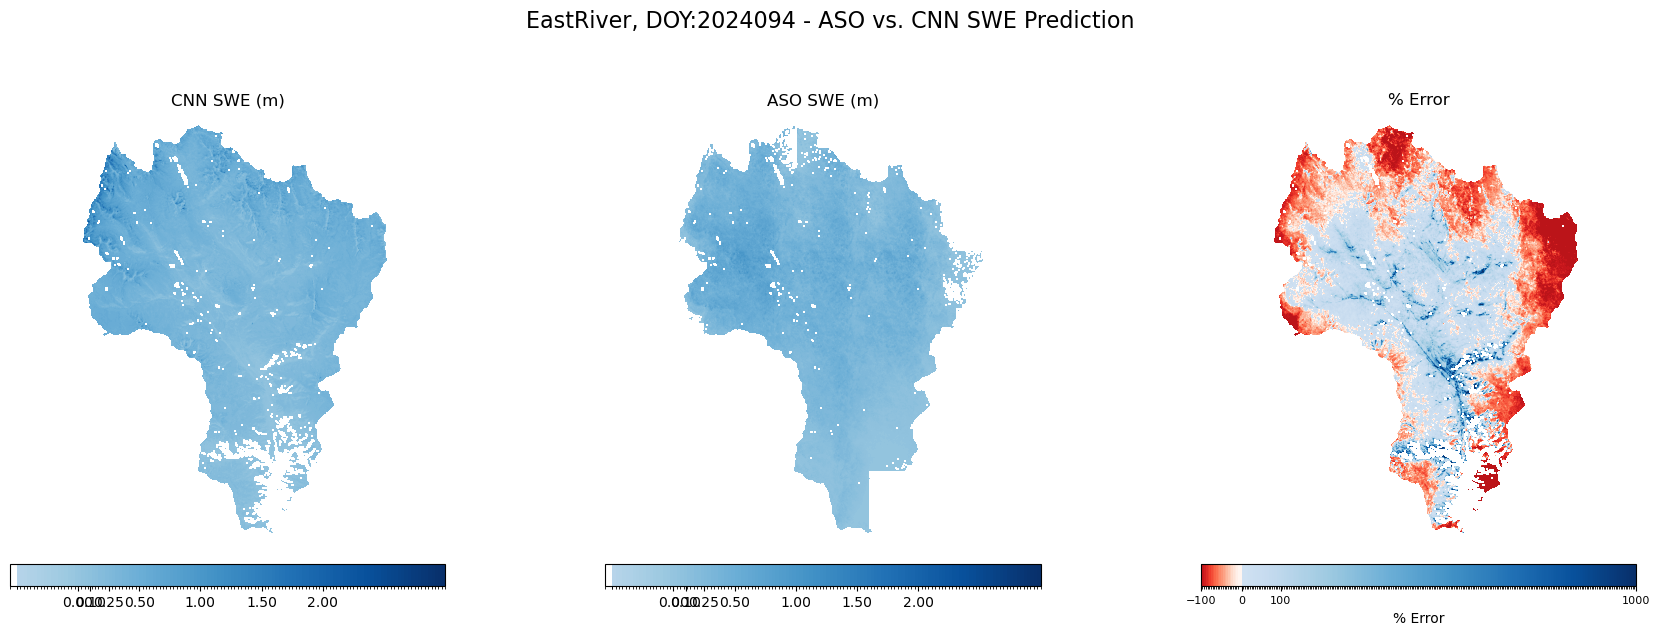

In [8]:
# plot rasters
raster_paths =[validASO, pred_path, precentErr]
titles = ["CNN SWE (m)", "ASO SWE (m)", "% Error"]
raster_data = []

for i, path in enumerate(raster_paths):
    with rasterio.open(path) as src:
        data = src.read(1).astype(float)
        nodata = src.nodata
        
        # Handle nodata properly
        if nodata is not None:
            if np.isnan(nodata):
                # For NaN nodata, the data already has NaN where invalid
                # No additional masking needed
                pass
            else:
                # For numeric nodata values
                data[data == nodata] = np.nan
        
        # Clip the percent error raster only (3rd one)
        if i == 2:
            data = np.clip(data, -100, 1000)
        raster_data.append(data)
# Rename for clarity
cnn_swe = raster_data[0]
aso_swe = raster_data[1]
error_raw = raster_data[2]

cnn_masked = np.ma.masked_where((cnn_swe <= 0), cnn_swe)
aso_masked = np.ma.masked_where((aso_swe <= 0), aso_swe)

# Mask error where both CNN and ASO are 0 or nan
error_mask = (
(np.isnan(cnn_swe) | (cnn_swe == 0)) &
(np.isnan(aso_swe) | (aso_swe == 0))
)

# Apply the mask
error_masked = np.copy(error_raw)
error_masked[error_mask] = np.nan
# SWE range from CNN & ASO
vmin_swe = np.nanmin(np.stack(raster_data[:2]))
vmax_swe = np.nanmax(np.stack(raster_data[:2]))

# Error range (symmetric)
err_max = np.nanmax(np.abs(raster_data[2]))
first_data = raster_data[0]
masked_first = np.full_like(first_data, np.nan)
masked_first[first_data == -1] = -1
masked_first[first_data == 0] = 0
masked_first[first_data > 0] = first_data[first_data > 0]

# Get colormaps and norms
swe_cmap, swe_norm = get_swe_custom_cmap(vmin=0, vmax=3)
swe_cmap, swe_norm = get_swe_custom_cmap(vmin=0, vmax=3)
error_cmap, error_norm = get_red_blue_error_cmap(vmin=-100, vcenter=0, vmax=1000)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# CNN SWE with custom blue/transparent/white colormap
im0 = axes[0].imshow(cnn_masked, cmap=swe_cmap, norm=swe_norm)
axes[0].set_title(titles[0])
axes[0].axis('off')
swe_ticks = [0, 0.1, 0.25, 0.5, 1, 1.5, 2]
fig.colorbar(im0, ax=axes[0], orientation='horizontal', fraction=0.046, pad=0.04, ticks=swe_ticks)

# ASO SWE with viridis
im1 = axes[1].imshow(aso_masked, cmap=swe_cmap, norm=swe_norm)
axes[1].set_title(titles[1])
axes[1].axis('off')
swe_ticks = [0, 0.1, 0.25, 0.5, 1, 1.5, 2]
fig.colorbar(im1, ax=axes[1], orientation='horizontal', fraction=0.046, pad=0.04, ticks=swe_ticks)

# Error with diverging RdBu
im2 = axes[2].imshow(error_masked, cmap=error_cmap, norm=error_norm)
axes[2].set_title(titles[2])
axes[2].axis('off')
axes[2].set_title(titles[2])
axes[2].axis('off')
bar_ticks = [-100, 0, 100, 1000]
cbar = fig.colorbar(im2, ax=axes[2], orientation='horizontal',
                    fraction=0.046, pad=0.04, ticks=bar_ticks)
cbar.set_label("% Error", fontsize=10)
cbar.ax.tick_params(labelsize=8)
fig.suptitle(f"{test_basin}, DOY:{test_doy} - ASO vs. CNN SWE Prediction", fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig(vettingWorkspace + f"Fig1a_{test_basin}_{test_doy}_SWE_comp.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def read_raster_info(path):
    with rasterio.open(path) as src:
        data = src.read(1)
        data = np.ma.masked_equal(data, src.nodata)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        return data, extent

def safe_read_shapefile(path):
    with fiona.open(path, 'r') as src:
        return gpd.GeoDataFrame.from_features(src, crs=src.crs)

## map all three rasters with a scale bar and labels and day stretch
## plot 1
# grab valid file path
meta_df = pd.read_csv(metaCSV)
meta_df = meta_df[meta_df['GroupNum'] == f"{group}"]
year = meta_df.iloc[0]['Year']
test_doy = meta_df.iloc[0]['TestDOY']
test_basin = meta_df.iloc[0]['TestBasin']
validASO = f"D:/ASOML/{domain}/{year}/SWE_processed/{test_basin}_{test_doy}_albn83_60m_SWE.tif"


year = meta_df.iloc[0]['Year']
trainA_doy = meta_df.iloc[0]['TrainDOYA']
trainA_basin = meta_df.iloc[0]['TrainBasinA']
trainB_doy = meta_df.iloc[0]['TrainDOYB']
trainB_basin = meta_df.iloc[0]['TrainBasinB']
tempStretch = meta_df.iloc[0]['TempStretch']
trainA = f"D:/ASOML/{domain}/{year}/SWE_processed/{trainA_basin}_{trainA_doy}_albn83_60m_SWE.tif"
trainB = f"D:/ASOML/{domain}/{year}/SWE_processed/{trainB_basin}_{trainB_doy}_albn83_60m_SWE.tif"
        
raster_paths = [trainA, trainB, validASO]
temporal_text = (f"Temporal Stretch (DOY):{tempStretch}\n"
                 f"Train {trainA_basin}: {trainA_doy}\n"
                 f"Train {trainB_basin}: {trainB_doy}\n"
                 f"Test {test_basin}: {test_doy}\n")

cities = safe_read_shapefile(basemap + "USA_Cities_albn83.shp")
parks = safe_read_shapefile(basemap + "USA_NatStateParks_albn83.shp")
states = safe_read_shapefile(basemap + "USA_States_albn83.shp")

# get metadata for shapefiles
parks_summary = parks[['NAME', 'Shape__Are']].head(5)
if isinstance(parks_summary, gpd.GeoDataFrame):
    parks_summary = parks_summary.drop(columns='geometry')

cities_summary = cities[['NAME']].head(5)
if isinstance(cities_summary, gpd.GeoDataFrame):
    cities_summary = cities_summary.drop(columns='geometry')

# Read all rasters first to get combined extent
all_extents = []
all_rasters = []

for path in raster_paths:
    data, extent = read_raster_info(path)
    all_rasters.append((data, extent))
    all_extents.append(extent)

# Compute combined extent
all_lefts, all_rights, all_bottoms, all_tops = zip(*all_extents)
combined_extent = [min(all_lefts), max(all_rights), min(all_bottoms), max(all_tops)]

# get values in extent
bbox_polygon = box(combined_extent[0], combined_extent[2], combined_extent[1], combined_extent[3])
parks_in_extent = parks[parks.geometry.intersects(bbox_polygon)]
cities_in_extent = cities[cities.geometry.intersects(bbox_polygon)]

# Plot
fig, ax = plt.subplots(figsize=(12, 10))

raster_labels = [f'Train: {trainA_basin}', f'Train: {trainB_basin}', f'Test: {test_basin}']  
for i, ((data, extent), label) in enumerate(zip(all_rasters, raster_labels)):
    ax.imshow(data, extent=extent, cmap='gist_gray', origin='upper', alpha=1.0) 
    x_text = extent[0] + (extent[1] - extent[0]) * 0.02
    y_text = extent[3] - (extent[3] - extent[2]) * (0.05 + 0.05 * i)
    ax.text(x_text, y_text, label, color='white', fontsize=12, weight='bold',
            bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.3'))

# plot basemap data
cities.plot(ax=ax, edgecolor='black', facecolor='black', linewidth=1, label='Towns')
parks.plot(ax=ax, facecolor='green', alpha=0.3, label='National and State Parks')
states.plot(ax=ax, edgecolor='red', facecolor='none', linestyle='--', linewidth=1, label='State Lines')

# for data, extent in all_rasters:
#     ax.imshow(data, extent=extent, cmap='gist_grey', origin='upper')

scalebar = ScaleBar(1, units="m", location='lower right')  # 1 unit = 1 meter
ax.add_artist(scalebar)

ax.annotate('N', xy=(0.95, 0.15), xytext=(0.95, 0.05),
            arrowprops=dict(facecolor='black', width=4, headwidth=10),
            ha='center', va='center', fontsize=12,
            xycoords='axes fraction')

ax.set_xlim(combined_extent[0], combined_extent[1])
ax.set_ylim(combined_extent[2], combined_extent[3])
ax.set_title("Spatial Extent of Test and Train Data")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

ax.text(0.2, -0.15, temporal_text,
        transform=ax.transAxes,
        fontsize=11,
        ha='right',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black", alpha=0.8))

# Create custom legend handles
legend_handles = [
    mpatches.Patch(color='black', label='Towns'),
    mpatches.Patch(color='green', alpha=0.3, label='National and State Parks/Forests'),
    mpatches.Patch(edgecolor='red', facecolor='none', linestyle='--', label='State Lines', linewidth=1),
]

ax.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1, -0.05))

xmin, xmax, ymin, ymax = combined_extent

for idx, row in cities_in_extent.iterrows():
    centroid = row.geometry.centroid
    x, y = centroid.x, centroid.y
    # Only label if centroid is inside the combined raster extent bounds
    if (xmin <= x <= xmax) and (ymin <= y <= ymax):
        ax.text(x, y, row['NAME'], fontsize=16, color='gray')
plt.grid(True)
plt.savefig(vettingWorkspace + f"Fig1_SpatialDis_TestTrain.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# make a compass rose
clipped_aspect_path = vettingWorkspace + f"{test_basin}_aspect.tif"
# resample aspect
align_raster(
    input_raster_path=aspect_CON,
    reference_raster_path=pred_path,
    output_raster_path=clipped_aspect_path,
    resampling_method=Resampling.nearest
)

with rasterio.open(pred_path) as swe_src:
    swe = swe_src.read(1).astype(float)
    swe[swe == swe_src.nodata] = np.nan

with rasterio.open(validASO) as aso_src:
    aso = aso_src.read(1).astype(float)
    aso[aso == aso_src.nodata] = np.nan

with rasterio.open(clipped_aspect_path) as asp_src:
    aspect = asp_src.read(1).astype(float)
    aspect[aspect == asp_src.nodata] = np.nan

# Wrap 360 to 0
aspect = aspect % 360

# Define 8 bins: N, NE, E, SE, S, SW, W, NW
bin_edges = np.arange(0, 361, 45)  # 0, 45, ..., 360
bin_labels = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
bin_centers_deg = (bin_edges[:-1] + bin_edges[1:]) / 2  # 22.5, 67.5, ...

# Bin each pixel by aspect direction
aspect_bins = np.digitize(aspect, bin_edges, right=False)
aspect_bins[aspect_bins == 9] = 1  # wrap 360° back to 0°

aso_means = []
cnn_means = []
for i in range(1, 9):  # Aspect bins 1–8
    mask = (aspect_bins == i)

    # ASO mean
    aso_val = np.nanmean(aso_swe[mask])
    aso_means.append(aso_val)

    # CNN mean
    cnn_val = np.nanmean(cnn_swe[mask])
    cnn_means.append(cnn_val)

# Wrap values and angles for full compass closure
angles_rad = np.deg2rad(bin_centers_deg)
angles_rad = np.append(angles_rad, angles_rad[0])
aso_means.append(aso_means[0])
cnn_means.append(cnn_means[0])

# Wrap for polar closure
angles_rad = np.deg2rad(bin_centers_deg)
angles_rad = np.append(angles_rad, angles_rad[0])
# mean_swe_per_bin.append(mean_swe_per_bin[0])

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': 'polar'})

for ax, data, title in zip(axs, [cnn_means, aso_means], ["CNN SWE (m)", "ASO SWE (m)"]):
    bars = ax.bar(
        angles_rad,
        data,
        width=np.deg2rad(45),
        bottom=0,
        color='skyblue',
        edgecolor='black',
        align='center'
    )

    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.deg2rad(bin_centers_deg))
    ax.set_xticklabels(bin_labels)
    ax.set_rlabel_position(135)
    ax.set_ylim(0, 0.5)  # Adjust as needed based on max SWE
    ax.set_title(title, fontsize=10, y=1.1)
    ax.tick_params(axis='y', labelsize=8)
    ax.yaxis.grid(True)

fig.suptitle(f"Mean SWE by Aspect – {test_basin}, DOY: {test_doy}", fontsize=12, y=1.08)
plt.tight_layout()
plt.savefig(vettingWorkspace + f"Fig1b_{test_basin}_{test_doy}_SWE_aspect.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# elevation bar graphs
# make a compass rose
clipped_elev_path = vettingWorkspace + f"{test_basin}_elev.tif"
# resample aspect
align_raster(
    input_raster_path=elev_path,
    reference_raster_path=pred_path,
    output_raster_path=clipped_elev_path,
    resampling_method=Resampling.nearest
)

# Read ASO SWE
with rasterio.open(validASO) as aso_src:
    aso_swe = aso_src.read(1).astype(float)
    aso_nodata = aso_src.nodata
    aso_swe[(aso_swe == -1) | (aso_swe == aso_nodata) | (aso_swe < 0)] = np.nan

# Read CNN SWE
with rasterio.open(pred_path) as cnn_src:
    cnn_swe = cnn_src.read(1).astype(float)
    cnn_nodata = cnn_src.nodata
    cnn_swe[(cnn_swe == -1) | (cnn_swe == cnn_nodata) | (cnn_swe < 0)] = np.nan

with rasterio.open(clipped_elev_path) as elev_src:
    elevation = elev_src.read(1).astype(float)
    elevation[elevation == elev_src.nodata] = np.nan

# pick bands
min_elev = 1000
max_elev = 4400
bin_width = 250
elev_bins = np.arange(min_elev, max_elev + bin_width, bin_width)
elev_labels = [f"{low}-{low+bin_width}" for low in elev_bins[:-1]]

# Digitize elevation
elev_bin_idx = np.digitize(elevation, elev_bins)

aso_means = []
cnn_means = []

for i in range(1, len(elev_bins)):
    mask = elev_bin_idx == i
    aso_means.append(np.nanmean(aso_swe[mask]))
    cnn_means.append(np.nanmean(cnn_swe[mask]))

# Determine y-axis max for consistent scaling
ymax = max(np.nanmax(aso_means), np.nanmax(cnn_means)) * 1.1

# Bar positions
x = np.arange(len(elev_labels))

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# CNN bar plot
axes[0].bar(x, cnn_means, color='skyblue', edgecolor='black')
axes[0].set_xticks(x)
axes[0].set_xticklabels(elev_labels, rotation=45, ha='right')
axes[0].set_ylabel("Mean SWE (m)")
axes[0].set_xlabel("Elevation Band (m)")
axes[0].set_title("CNN SWE by Elevation")
axes[0].set_ylim(0, ymax)
axes[0].grid(axis='y')

# ASO bar plot
axes[1].bar(x, aso_means, color='steelblue', edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(elev_labels, rotation=45, ha='right')
axes[1].set_xlabel("Elevation Band (m)")
axes[1].set_title("ASO SWE by Elevation")
axes[1].set_ylim(0, ymax)
axes[1].grid(axis='y')

# Add overall title and save
fig.suptitle(f"Mean SWE by 250 m Elevation Band – {test_basin}, DOY: {test_doy}", fontsize=14, y=1.08)
plt.tight_layout()
plt.savefig(vettingWorkspace + f"Fig1c_{test_basin}_{test_doy}_SWE_elevation.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# get scatter plot
# Load both rasters
with rasterio.open(validASO) as aso_src, rasterio.open(pred_path) as cnn_src:
    aso = aso_src.read(1).astype(float)
    cnn = cnn_src.read(1).astype(float)

    # Handle nodata
    aso_nodata = aso_src.nodata
    cnn_nodata = cnn_src.nodata

    aso[(aso == -1) | (aso == aso_nodata)] = np.nan
    cnn[(cnn == -1) | (cnn == cnn_nodata)] = np.nan

# Build valid mask: only where both ASO and CNN are valid
valid_mask = (~np.isnan(aso)) & (~np.isnan(cnn))

# Extract valid values
aso_valid = aso[valid_mask]
cnn_valid = cnn[valid_mask]

rmse = np.sqrt(mean_squared_error(aso_valid, cnn_valid))
mse  = mean_squared_error(aso_valid, cnn_valid)
mae  = mean_absolute_error(aso_valid, cnn_valid)

print(f"RMSE: {rmse:.3f} m")
print(f"MSE : {mse:.3f} m²")
print(f"MAE : {mae:.3f} m")

plt.figure(figsize=(6,6))
plt.scatter(aso_valid, cnn_valid, alpha=0.3, s=5, color='blue', edgecolors='none')

# Plot 1:1 reference line
lims = [0, max(np.nanmax(aso_valid), np.nanmax(cnn_valid)) * 1.05]
plt.plot(lims, lims, 'k--', label='1:1 Line')

plt.xlabel("ASO SWE (m)")
plt.ylabel("CNN SWE (m)")
plt.title(f"{test_basin}_{test_doy}: SWE Comparison\nRMSE: {rmse:.2f} | MAE: {mae:.2f}")
plt.xlim(lims)
plt.ylim(lims)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(vettingWorkspace + f"Fig1d_{test_basin}_{test_doy}_SWE_scatter.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# error stats
csv_path = errorComps + "error_summary_stats.csv"

error_stats = {
    'GroupNum':[group],
    'basin': [test_basin],
    'doy': [test_doy],
    'year': [year],
    'RMSE': [rmse],
    'MSE': [mse],
    'MAE': [mae],
    "n_valid": len(aso_valid)
}

df = pd.DataFrame(error_stats)

# Append or write new file
if os.path.exists(csv_path):
    df.to_csv(csv_path, mode='a', header=False, index=False)
else:
    df.to_csv(csv_path, index=False)


# out of loop:
metadata_df = pd.read_csv(metaCSV)
metadata_df = metadata_df[["GroupNum", "Dist_TrainA(m)", "Dist_TrainB(m)", 'TempStretch']]

error_df = pd.read_csv(csv_path)
merged_df = pd.merge(error_df, metadata_df, on='GroupNum', how='inner')


In [ ]:
merged_df['AvgDist(m)'] = (merged_df['Dist_TrainA(m)'] + merged_df['Dist_TrainB(m)'])/2

In [ ]:
merged_df

In [ ]:
# Melt to long form for easier plotting
df_plot = merged_df.melt(id_vars=['GroupNum', 'AvgDist(m)'], 
                    value_vars=['RMSE', 'MSE', 'MAE'],
                    var_name='Metric', value_name='Error')

# Create line plot
plt.figure(figsize=(10, 6))

# Plot each metric line
for metric in df_plot['Metric'].unique():
    subset = df_plot[df_plot['Metric'] == metric]
    plt.plot(subset['AvgDist(m)'], subset['Error'], marker='o', label=metric)
    
    # Annotate with group labels
    for i, row in subset.iterrows():
        plt.text(row['AvgDist(m)'] + 0.3, row['Error'], row['group'], fontsize=9)

# Labeling
plt.xlabel('Error over Distance from training and test samples')
plt.ylabel('Error Value(m)')
plt.title('Error Metrics vs Distance')
plt.legend(title='Metric')
plt.grid(True)
plt.tight_layout()
plt.show()